# KNN Exercise

![iris](images/iris.jpg)

We are going to use the famous **iris data set** again. 

The dataset consists of four attributes, which can be used to distinguish different iris species: 
* sepal-width
* sepal-length
* petal-width 
* petal-length. 


The task is to predict the class to which these plants belong. There are three classes in the dataset: **Iris-setosa, Iris-versicolor and Iris-virginica.** 

Further details of the dataset are available here.
https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

## Task

1. Please import and pre-process the data (as far as it's necessary). Afterwards split it in a train and test set, fit a KNN model and make predictions on the test set. The last step is to evaluate your model. Try to also scale your data and fit the model to the unscaled and scaled data. Can you see a difference in performance? 
If you can't it's because the original features are all on a very similar scale. Try multiplying one of the features by a factor of 10 and fitting the model to unscaled and scaled data. The difference should now be obvious 

2. Please also calculate the accuracy for K values of 1 to 40. In each iteration the accuracy for the predicted values of the test set is calculated and the result is appended to an error list.
The next step is to plot the accuracy values against K values.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
df_iris = load_iris(as_frame=True).frame

In [9]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [13]:
cols = df_iris.columns.tolist()
#replace the spaces with underscores and make all lowercase, also remoce (cm) 
new_cols = [col.replace(' ', '_').replace('_(cm)', '').lower() for col in cols]
df_iris.columns = new_cols
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [15]:
X = df_iris.drop(columns=['target'])
y = df_iris['target']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
df_train = pd.concat([X_train, y_train], axis=1)

In [39]:
numerical_features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
num_sscale = Pipeline([
    ('scaler', StandardScaler())
])

num_mmscale = Pipeline([
    ('scaler', MinMaxScaler())
])

num_noscale = 'passthrough'


knn_sscale = Pipeline([
    ('transformer', num_sscale),
    ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

knn_sscale.fit(X_train, y_train)
y_pred = knn_sscale.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))




Accuracy: 0.93


In [32]:
y_pred = knn_sscale.predict(X_test)
y_pred.shape

(30,)

Accuracy: 0.93
--------------------------------------------------


<Axes: >

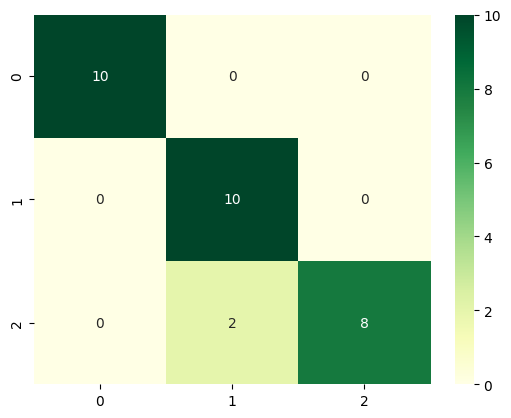

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
print("-----"*10)

# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn')

In [40]:
# usage of GridSearchCV to find the best parameters
pipe = Pipeline([
    ('transformer', StandardScaler()),
    ('knn', KNeighborsClassifier())
]) 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'transformer': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21, 27, 31, 40],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


gs.fit(X_train, y_train)
print("Best parameters found: ", gs.best_params_)
print("Best cross-validation accuracy: ", gs.best_score_.round(2))

Fitting 5 folds for each of 99 candidates, totalling 495 fits
Best parameters found:  {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'transformer': 'passthrough'}
Best cross-validation accuracy:  0.98


In [42]:
# calculate the accuracy score for k = 1 to 40 and save them in a dataframe
results = []
for k in range(1, 41):
    knn = Pipeline([
        ('transformer', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k, metric='euclidean'))
    ])
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({'n_neighbors': k, 'accuracy': acc})

<Axes: xlabel='n_neighbors', ylabel='accuracy'>

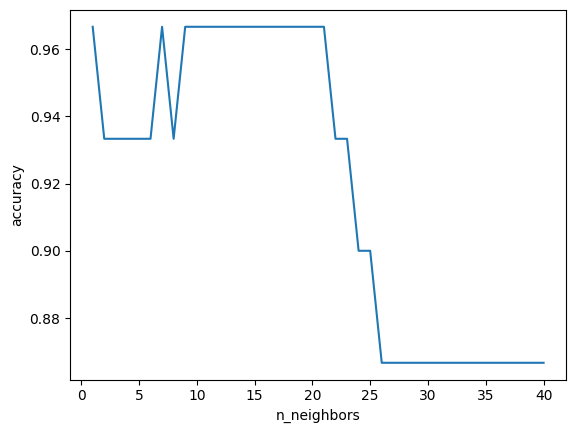

In [43]:
#plot the results 
results_df = pd.DataFrame(results)
sns.lineplot(data=results_df, x='n_neighbors', y='accuracy')

### Very useful example to handle more complex data with different preprocessors in the GridSearchCV


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

num_cols = [...]
cat_cols = [...]
ord_cols = [...]
special_cols = [...]  # if you truly need special handling

# Variant A: StandardScaler for numeric
preproc_std = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ("ord", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ord", OrdinalEncoder(categories=[...]))]), ord_cols),
        ("special", Pipeline([...]), special_cols),
    ],
    remainder="drop",
)

# Variant B: MinMaxScaler for numeric
preproc_mm = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", MinMaxScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ("ord", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ord", OrdinalEncoder(categories=[...]))]), ord_cols),
        ("special", Pipeline([...]), special_cols),
    ],
    remainder="drop",
)

# Variant C: No scaling for numeric
preproc_none = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("scaler", "passthrough")]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
        ("ord", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ord", OrdinalEncoder(categories=[...]))]), ord_cols),
        ("special", Pipeline([...]), special_cols),
    ],
    remainder="drop",
)

In [ ]:
#placeholder pipeline
pipe = Pipeline([
    ("preprocessor", preproc_std),  # placeholder
    ("model", LogisticRegression(max_iter=1000, random_state=RSEED))
])

param_grid = {
    "preprocessor": [preproc_std, preproc_mm, preproc_none],
    "model__C": [0.1, 1, 10],
    "model__class_weight": [None, "balanced"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

gs = GridSearchCV(pipe, param_grid=param_grid, scoring="recall", cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

### Different model methods and preprocessors for GridSearchCV

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Shared sub-pipelines
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

ord_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ord", OrdinalEncoder(categories=[...]))   # if you have ordinal columns
])

num_pipe_std = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

num_pipe_mm = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

num_pipe_none = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", "passthrough")
])

# Preprocessor variants
preproc_std = ColumnTransformer([
    ("num", num_pipe_std, num_cols),
    ("cat", cat_pipe, cat_cols),
    ("ord", ord_pipe, ord_cols),     # remove this line if you have no ordinal cols
], remainder="drop")

preproc_mm = ColumnTransformer([
    ("num", num_pipe_mm, num_cols),
    ("cat", cat_pipe, cat_cols),
    ("ord", ord_pipe, ord_cols),
], remainder="drop")

preproc_none = ColumnTransformer([
    ("num", num_pipe_none, num_cols),
    ("cat", cat_pipe, cat_cols),
    ("ord", ord_pipe, ord_cols),
], remainder="drop")

In [ ]:
#placeholder pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("preprocessor", preproc_std),  # placeholder
    ("model", LogisticRegression()) # placeholder
])

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

preprocs_all = [preproc_std, preproc_mm, preproc_none]

param_grid = [
    # Logistic Regression: compare preprocessors + tune C / class_weight
    {
        "preprocessor": preprocs_all,
        "model": [LogisticRegression(max_iter=2000, random_state=RSEED)],
        "model__C": [0.01, 0.1, 1, 10],
        "model__class_weight": [None, "balanced"],
        "model__solver": ["lbfgs"],
        "model__penalty": ["l2"],
    },

    # KNN: usually scaling matters; you can restrict to scaled preprocessors if you want
    {
        "preprocessor": [preproc_std, preproc_mm, preproc_none],  # or just [preproc_std, preproc_mm]
        "model": [KNeighborsClassifier()],
        "model__n_neighbors": [3, 5, 7, 11, 21],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"],
    },

    # SVM: scaling almost always matters; usually you would drop preproc_none
    {
        "preprocessor": [preproc_std, preproc_mm],
        "model": [SVC(probability=True, random_state=RSEED)],
        "model__C": [0.1, 1, 10],
        "model__kernel": ["rbf", "linear"],
        "model__gamma": ["scale", "auto"],
        "model__class_weight": [None, "balanced"],
    },

    # Random Forest: scaling irrelevant; force no-scale so you don't waste grid slots
    {
        "preprocessor": [preproc_none],
        "model": [RandomForestClassifier(random_state=RSEED)],
        "model__n_estimators": [200, 500],
        "model__max_depth": [None, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
]

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="recall",     # choose based on your objective
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best CV score:", gs.best_score_)
print("Best params:", gs.best_params_)
print("Best model object:", gs.best_estimator_.named_steps["model"])